Importing useful libraries and importing the drive for the dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import torch
import torch.nn as nn
import sklearn
import pandas as pd
import io
import math
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Mounted at /content/drive
/content/drive/My Drive


Importing the data

In [5]:
pddata = pd.read_csv('GSM1586785_ScrH-12A_Exd_14mer_cg.csv.zip', compression='zip', error_bad_lines=False, skiprows=1)

In [6]:
pddata = pddata.to_numpy()
RelKa = pddata[:, -1]
training_data = pddata[:, 2:-1]

Some helpers function for the analysis below

In [7]:
def drop_outliers(x, y, outliers):
    x = np.delete(x, outliers, axis=0)
    y = np.delete(y, outliers, axis=0)
    return x, y

In [8]:
from sklearn import preprocessing

def standardize(x):
    scaler = preprocessing.StandardScaler().fit(training_data)
    x = scaler.transform(x)
    return x

In [9]:
def split_RelKa(y, p):
  return np.array([1 if value > p else 0 for value in y])

In [10]:
from sklearn.ensemble import RandomForestClassifier

def predict_with_Random_Forests(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)  
    return y_pred

In [11]:
from sklearn import metrics

def return_accuracy(y_test, y_pred, verbose=1):
    C = metrics.confusion_matrix(y_test, y_pred)
    accuracy = np.trace(C) / len(y_test)
    if verbose == 1:
        print("The number of true negatives is:", C[0, 0])
        print("The number of false negatives is:", C[1,0])
        print("The number of false positives is:", C[0,1])  
        print("The number of true positives is:", C[1,1])
        print("The accuracy is:", accuracy)
        print("The accuracy on the 1's is ", 1 / np.sum(y_test == 1) * (np.sum(y_test == 1) - C[1, 0]))
        print("The accuracy on the 0's is ", 1 / np.sum(y_test == 0) * (np.sum(y_test == 0) - C[0, 1]))
    return accuracy

In [13]:
import random

def undersampling(X, y, ratios, intervals):
    undersampled_training_data = np.zeros(training_data.shape[1])
    undersampled_training_data = undersampled_training_data[..., np.newaxis].T
    undersampled_RelKa = np.array([])
    for i in range(len(intervals)-1):
        indices = np.where(np.logical_and(intervals[i] <= RelKa, RelKa <= intervals[i+1]))[0]
        sample_length = np.int(ratios[i]*len(indices))
        random_picked = random.sample(list(np.arange(0, len(indices) + 1)), sample_length)
        training_to_add = training_data[indices[0] + random_picked, :]
        undersampled_training_data = np.concatenate([undersampled_training_data, training_to_add], axis=0)
        RelKa_to_add = RelKa[indices[0] + random_picked]
        undersampled_RelKa = np.concatenate([undersampled_RelKa, RelKa_to_add], axis=0)
    critical_indices = np.where(RelKa >= 0.7)[0]
    critical_RelKa = RelKa[critical_indices]
    critical_samples = training_data[critical_indices, :]
    undersampled_training_data = np.concatenate([undersampled_training_data, critical_samples], axis=0)
    undersampled_RelKa = np.concatenate([undersampled_RelKa, critical_RelKa], axis=0)
    undersampled_training_data = np.delete(undersampled_training_data, 0, axis=0)
    return undersampled_training_data, undersampled_RelKa

In [ ]:
def initialize_clusters(data, k):
    """randomly initialize the k cluster centers (the means). Make sure you choose k clusters from the data itself,
             or ensure otherwise that your initializations have the same scale as the data
    
    Args:
        data: shape = (N, d). original data. 
        k: integer number. predefined number of clusters for the k-means algorithm. 
    Returns:
        numpy array with shape (k, d) which corresponds to the k initial clusters.
    """
    uniform_choice = random.sample(list(np.arange(0, data.shape[0])), k)
    d = data.shape[1]
    cluster_means = np.zeros((k, d))
    for i in range(len(uniform_choice)):
        cluster_means[i, :] = data[uniform_choice[i], :]
    return cluster_means

In [ ]:
def build_distance_matrix(data, mu):
    """builds a distance matrix.
    
    Args:
        data: numpy array of shape = (N, d). original data. 
        mu:   numpy array of shape = (k, d). Each row corresponds to a cluster center.
    Returns:
        numpy array of shape (N, k):
            squared distances matrix,  
            the value row i column j corresponds to the squared distance of datapoint i with cluster center j.
    """
    M = np.zeros((data.shape[0], mu.shape[0]))
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            M[i,j] = np.linalg.norm(data[i, :] - mu[j, :])
    return M

In [ ]:
def update_kmeans_parameters(data, mu_old):
    """compute one step of the kmeans algorithm: using mu_old, find to which cluster each datapoint belongs to, 
            then update the parameter cluster centers.
    
    Args:
        data:   numpy array of shape = (N, d). original data. 
        mu_old: numpy array of shape = (k, d). Each row corresponds to a cluster center.
    Returns:
        losses: shape (N, ), contains the (old) squared distances of each data point to its (old) cluster mean (computed from mu_old).
        assignments: vector of shape (N, ) which contains the cluster associated to each data point.
        mu: updated vector mu of shape (k, d) where each row corresponds to the new cluster center.
    """
    k = mu_old.shape[0]
    d = mu_old.shape[1]
    N = data.shape[0]
    all_losses = build_distance_matrix(data, mu_old)
    mu = np.zeros((k, d))
    assignments = np.array([np.argmin(all_losses[i, :]) for i in range(N)])
    losses = np.array([np.linalg.norm(data[i,:] - mu_old[assignments[i], :]) for i in range(N)])
    for i in range(k):
        assigned_indices = np.where(assignments == i)[0]
        mu[i, :] = np.mean(data[assigned_indices, :], axis=0)
    return losses, assignments, mu

In [ ]:
def kmeans(data, k, max_iters, threshold, verbose = True):
    """run the k-means algorithm."""
    output_figure = "kmeans_figures/"
    # initialize the cluster.
    mu_old = initialize_clusters(data, k)
    # init some empty lists to store the result.
    loss_list = []

    # start the kmeans algorithm.
    for iteration in range(max_iters):
        # update z and mu
        losses, assignments, mu = update_kmeans_parameters(data, mu_old)
        # calculate the average loss over all points
        average_loss = np.mean(losses)
        loss_list.append(average_loss)
        if verbose:
            print("The current iteration of k-means is: {i}, \
                   the average loss is {l}.".format(i=iteration, l=average_loss))
        # check convergence
        if iteration > 0 and np.abs(loss_list[-1] - loss_list[-2]) < threshold:
            break
        # update k-means information.
        mu_old = mu
    return average_loss, assignments

WE FIRTS TRY TO DO A PREDICTION WITHOUT ANY OUTLIER REMOTION TO HAVE A COMPARISON AND WITHOUT ANY CLUSTERING TO HAVE A COMPARISON

In [56]:
training_data = standardize(training_data)
RelKa_tilda = split_RelKa(RelKa, 0.8)
indices = [i for i in range(len(training_data))]
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(training_data, RelKa_tilda, indices, train_size=0.7, random_state=42)

In [57]:
y_pred = predict_with_Random_Forests(X_train, X_test, y_train, y_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 51150
The number of false negatives is: 22
The number of false positives is: 0
The number of true positives is: 3
The accuracy is: 0.9995701025891549
The accuracy on the 1's is  0.12
The accuracy on the 0's is  1.0


WE SEE THAT THE ACCURACY IS HIGH BUT WE ARE PREDICTING VERY POORLY THE CLASS 1

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 120, num = 5)]
min_samples_split = [2, 5, 8]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 3, cv = 4, verbose=10, scoring=make_scorer(f1_score, average='weigthed'))
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=110...
[CV 1/4; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=0.993 total time= 3.9min
[CV 2/4; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=110...
[CV 2/4; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=0.993 total time= 4.0min
[CV 3/4; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=110...
[CV 3/4; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=0.992 total time= 4.0min
[CV 4/4; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=110...
[CV 4/4; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=0.993 total time= 4.1min
[CV 1/4; 2/3] START min_samples_leaf=2, min_samples_split=8, n_estimators=100...
[CV 1/4; 2/3] END min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.993 total tim

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=3,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 8],
                                        'n_estimators': [100, 105, 110, 115,
                                                         120]},
                   verbose=10)

In [ ]:
clf = RandomForestClassifier(n_estimators=110, min_samples_leaf=2, min_samples_split=5, criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 46447
The number of false negatives is: 263
The number of false positives is: 36
The number of true positives is: 408
The accuracy is: 0.9936590745217797


After tuning the parameters we see that the accuracy goes up to 60% on the 1's, but this value is still not satisfying (we want at least 80%-85%)

ISOLATION FORESTS ANOMALY DETECTION

In [23]:
from sklearn.ensemble import IsolationForest

def Anomaly_Detection_Isolation_Forests(x, change_split=True):
    random_state = np.random.RandomState(42)
    contamination = 'auto'
    threshold = np.random.uniform(-0.03, -0.02, 1)
    model = IsolationForest(n_estimators=120, max_samples='auto', contamination=contamination, random_state=random_state)
    model.fit(x)
    scores = model.decision_function(x)
    if change_split == False:
        anomaly_score = model.predict(x)
        outliers_indices = np.where(anomaly_score == -1)[0]
    if change_split == True:
        outliers_indices = split_outliers(threshold, scores)
    return contamination, scores, outliers_indices

def check_Isolation_Forests(contamination, outliers_indices):
  """
  Simply a check on the proper working of the IF algorithm
  """
    tol = 1.0e-02
    if contamination != 'auto':
        outliers_percentage = 1 / len(RelKa) * len(outliers_indices)
    assert np.abs(contamination-outliers_percentage) < tol

def check_boundary_decision(scores, p, verbose=1):
  """
  This function simply controls how many scores returned by the IF algorithm 
  are likely to be misclassified
  """
    indecision_percentage = 1 / len(RelKa) * np.count_nonzero(np.abs(scores) <= p)
    if verbose == 1:
        plt.hist(scores)
        plt.show()
        print("The indecision percentage around", p,  "is", indecision_percentage)
        print("The percentage of outliers detected is", 1 / len(scores) * len(np.where(scores < 0)[0]))

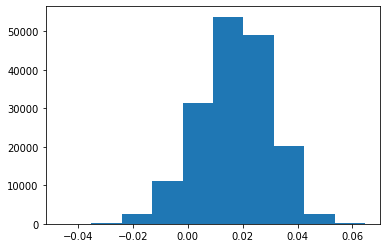

The indecision percentage around 0.02 is 0.5672001406964474
The percentage of outliers detected is 0.10294290069175753


In [ ]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(training_data, change_split=False)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [ ]:
training_data, RelKa = drop_outliers(training_data, RelKa, outliers_indices)
training_data = standardize(training_data)
RelKa_tilda = split_RelKa(RelKa, 0.8)

In [ ]:
indices = [i for i in range(len(training_data))]
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(training_data, RelKa_tilda, indices, train_size=0.7, random_state=42)

In [ ]:
y_pred = predict_with_Random_Forests(X_train, X_test, y_train, y_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 45880
The number of false negatives is: 24
The number of false positives is: 1
The number of true positives is: 1
The accuracy is: 0.9994554088790136


We see that we have a problem with a large number of false negatives, namely with incorrectly predictions of the negative class

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_data, RelKa_tilda, train_size=0.7, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=10, scoring=make_scorer(f1_score, average="weighted"))
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 1/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.991 total time= 1.5min
[CV 2/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 2/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 total time= 1.6min
[CV 3/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 3/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.991 total time= 1.6min
[CV 4/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 4/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.991 total time= 1.6min
[CV 5/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 5/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 tot

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 125, 150, 175,
                                                         200]},
                   verbose=10)

In [20]:
# print(rf_random.best_params_)
clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=2, criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1}


UNDERSAMPLING TECHNIQUE TO BALANCE THE DATASET

In [14]:
ratios = np.array([0.1])
intervals = 0.2 * np.arange(0, 2)
undersampled_training_data, undersampled_RelKa = undersampling(training_data, RelKa, ratios, intervals)
undersampled_training_data = standardize(undersampled_training_data)
undersampled_RelKa = split_RelKa(undersampled_RelKa, 0.6)

In [15]:
undersampled_X_train, undersampled_X_test, undersampled_y_train, undersampled_y_test = train_test_split(undersampled_training_data, undersampled_RelKa, train_size=0.7, random_state=42)
undersampled_y_pred = predict_with_Random_Forests(undersampled_X_train, undersampled_X_test, undersampled_y_train, undersampled_y_test)
return_accuracy(undersampled_y_test, undersampled_y_pred, verbose=1)

The number of true negatives is: 3553
The number of false negatives is: 7
The number of false positives is: 1
The number of true positives is: 95
The accuracy is: 0.9978118161925602
The accuracy on the 1's is  0.9313725490196079
The accuracy on the 0's is  0.9997186268992685


0.9978118161925602

WE SEE THAT INCREASING THE NUMBER OF SAMPLES CRITICAL WE ALMOST HAVE 100 % ACCURACY BOTH ON 0'S AND 1'S AT THE COST OF DOING THE UNDERSAMPLING AND THE OVERSAMPLING OF THE PREVIOUS PARAGRAPH. WE TRY NOW TO ACHIEVE SIMILAR RESULTS BY PENALIZING ERRORS ON 1'S

WE PERFORM CROSS VALIDATION TO TUNE THE HYPERPARAMETERS OF THE RANDOM FOREST

In [16]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=10, scoring=make_scorer(f1_score, average='weighted'))
rf_random.fit(undersampled_X_train, undersampled_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START min_samples_leaf=4, min_samples_split=5, n_estimators=100..
[CV 1/5; 1/10] END min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.995 total time=   9.1s
[CV 2/5; 1/10] START min_samples_leaf=4, min_samples_split=5, n_estimators=100..
[CV 2/5; 1/10] END min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.992 total time=   8.7s
[CV 3/5; 1/10] START min_samples_leaf=4, min_samples_split=5, n_estimators=100..
[CV 3/5; 1/10] END min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.995 total time=   9.0s
[CV 4/5; 1/10] START min_samples_leaf=4, min_samples_split=5, n_estimators=100..
[CV 4/5; 1/10] END min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.994 total time=   8.9s
[CV 5/5; 1/10] START min_samples_leaf=4, min_samples_split=5, n_estimators=100..
[CV 5/5; 1/10] END min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.995 tot

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 125, 150, 175,
                                                         200]},
                   scoring=make_scorer(f1_score, average=micro), verbose=10)

In [21]:
# print(rf_random.best_params_)
clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=2, criterion='entropy')
clf.fit(undersampled_X_train, undersampled_y_train)
undersampled_y_pred = clf.predict(undersampled_X_test)
accuracy = return_accuracy(undersampled_y_test, undersampled_y_pred, verbose=1)

The number of true negatives is: 3554
The number of false negatives is: 8
The number of false positives is: 0
The number of true positives is: 94
The accuracy is: 0.9978118161925602
The accuracy on the 1's is  0.9215686274509803
The accuracy on the 0's is  1.0


TUNING THE PARAMETERS IN THE STANDARD WAY IS SLIGHTLY INCREASING THE ACCURACY ON THE 1'S, SO WE SHOULD TRY TO DO CROSS-VALIDATION USING THE F1 SCORE TO FURTHER IMPROVE

WE TRY NOW TO DETECT AND DROP OUTLIERS ON THE BALANCED DATASET TO SEE WHETHER THE PERFORMANCE IS IMPROVING

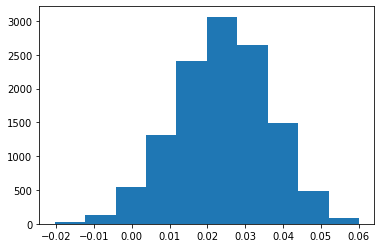

The indecision percentage around 0.02 is 0.026187126275061555
The percentage of outliers detected is 0.030860144451739985


In [24]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(undersampled_training_data, change_split=False)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [25]:
undersampled_training_data, undersampled_RelKa = drop_outliers(undersampled_training_data, undersampled_RelKa, outliers_indices)
undersampled_training_data = standardize(undersampled_training_data)
undersampled_RelKa = split_RelKa(undersampled_RelKa, 0.6)

In [26]:
undersampled_X_train, undersampled_X_test, undersampled_y_train, undersampled_y_test = train_test_split(undersampled_training_data, undersampled_RelKa, train_size=0.7, random_state=42)
undersampled_y_pred = predict_with_Random_Forests(undersampled_X_train, undersampled_X_test, undersampled_y_train, undersampled_y_test)
return_accuracy(undersampled_y_test, undersampled_y_pred, verbose=1)

The number of true negatives is: 3443
The number of false negatives is: 7
The number of false positives is: 0
The number of true positives is: 93
The accuracy is: 0.9980242732147897
The accuracy on the 1's is  0.93
The accuracy on the 0's is  1.0


0.9980242732147897

In [27]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=10, scoring=make_scorer(f1_score, average='weighted'))
rf_random.fit(undersampled_X_train, undersampled_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START min_samples_leaf=4, min_samples_split=10, n_estimators=100.
[CV 1/5; 1/10] END min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.992 total time=   8.3s
[CV 2/5; 1/10] START min_samples_leaf=4, min_samples_split=10, n_estimators=100.
[CV 2/5; 1/10] END min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.995 total time=   8.0s
[CV 3/5; 1/10] START min_samples_leaf=4, min_samples_split=10, n_estimators=100.
[CV 3/5; 1/10] END min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.995 total time=   8.8s
[CV 4/5; 1/10] START min_samples_leaf=4, min_samples_split=10, n_estimators=100.
[CV 4/5; 1/10] END min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.993 total time=   8.4s
[CV 5/5; 1/10] START min_samples_leaf=4, min_samples_split=10, n_estimators=100.
[CV 5/5; 1/10] END min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.99

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 125, 150, 175,
                                                         200]},
                   scoring=make_scorer(f1_score, average=micro), verbose=10)

In [35]:
# print(rf_random.best_params_)
clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=2, criterion='entropy')
clf.fit(undersampled_X_train, undersampled_y_train)
undersampled_y_pred = clf.predict(undersampled_X_test)
accuracy = return_accuracy(undersampled_y_test, undersampled_y_pred, verbose=1)

The number of true negatives is: 3443
The number of false negatives is: 9
The number of false positives is: 0
The number of true positives is: 91
The accuracy is: 0.9974597798475868
The accuracy on the 1's is  0.91
The accuracy on the 0's is  1.0


WE TRY TO MAKE THE SUBSAMPLING PROCEDURE MORE ELEGANT AND EFFICIENT BY CONSIDERING K-CLUSTERING, THEN TAKING A SUBSAMPLE FOR EACH CLUSTER (WE PERFORM THE CLUSTERING ONLY ON THE SAMPLES WITH RELKA'S BELOW 0.2) 

In [52]:
max_iters = 5
threshold = 1.0e-02
k = 5
indices = np.where(RelKa <= 0.2)[0]
redundant_training_data = training_data[indices, :]
redundant_RelKa = RelKa[indices]

average_loss, assignments = kmeans(redundant_training_data, k, max_iters, threshold)

The current iteration of k-means is: 0,                    the average loss is 6.913651290204287.
The current iteration of k-means is: 1,                    the average loss is 5.51839742076969.
The current iteration of k-means is: 2,                    the average loss is 5.3974221020446524.
The current iteration of k-means is: 3,                    the average loss is 5.350227764835033.
The current iteration of k-means is: 4,                    the average loss is 5.3174242010148305.
The current iteration of k-means is: 5,                    the average loss is 5.292021291232115.
The current iteration of k-means is: 6,                    the average loss is 5.273316762498283.
The current iteration of k-means is: 7,                    the average loss is 5.25977890279777.
The current iteration of k-means is: 8,                    the average loss is 5.250263920568093.
The current iteration of k-means is: 9,                    the average loss is 5.243452766213569.


In [53]:
import random

clustered_data = np.zeros(training_data.shape[1])
clustered_data = clustered_data[..., np.newaxis].T
clustered_RelKa = np.array([])
for i in range(k):
    # collect random_size casual samples from the i-th cluster
    assigned_indices = np.where(assignments == i)[0]
    # taking the samples and RelKa assigned to the i-th cluster
    assigned_data = redundant_training_data[assigned_indices, :]
    assigned_RelKa = redundant_RelKa[assigned_indices]
    # taking a random subsample
    random_picked = random.sample(list(np.arange(0, len(assigned_indices))), np.int(1/10 * len(assigned_indices)))
    data_to_add = assigned_data[random_picked, :]
    RelKa_to_add = assigned_RelKa[random_picked]
    # concatenate the subsample to the old clustered_data and clustered_RelKa
    clustered_data = np.concatenate([clustered_data, data_to_add])
    clustered_RelKa = np.concatenate([clustered_RelKa, RelKa_to_add])
# we delete the first row which was just for initialization
clustered_data = np.delete(clustered_data, 0, axis = 0)

In [54]:
# adding all the other samples (which represent less than 20% of the original dataset)
indices = np.where(RelKa > 0.2)[0]
clustered_data = np.concatenate([clustered_data, training_data[indices, :]])
clustered_RelKa = np.concatenate([clustered_RelKa, RelKa[indices]])

In [55]:
print(clustered_data.shape)
print(clustered_RelKa.shape)

(75687, 318)
(75687,)


In [56]:
clustered_RelKa = split_RelKa(clustered_RelKa, 0.6)
clustered_data = standardize(clustered_data)

In [57]:
clustered_X_train, clustered_X_test, clustered_y_train, clustered_y_test = train_test_split(clustered_data, clustered_RelKa, train_size=0.7, random_state=42)
clustered_y_pred = predict_with_Random_Forests(clustered_X_train, clustered_X_test, clustered_y_train, clustered_y_test)
return_accuracy(clustered_y_test, clustered_y_pred, verbose=1)

The number of true negatives is: 22416
The number of false negatives is: 111
The number of false positives is: 24
The number of true positives is: 156
The accuracy is: 0.9940546967895363
The accuracy on the 1's is  0.5842696629213483
The accuracy on the 0's is  0.9989304812834224


0.9940546967895363

Taking 20 clusters the accuracy on the 1's is lower than the accuracy with 10 clusters (61%), so we should decrease such a number for the kmeans

In [58]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=10, scoring=make_scorer(f1_score, average='weighted'))
rf_random.fit(clustered_X_train, clustered_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=175..
[CV 1/5; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=0.992 total time=  14.9s
[CV 2/5; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=175..
[CV 2/5; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=0.996 total time=  14.1s
[CV 3/5; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=175..
[CV 3/5; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=0.995 total time=  14.8s
[CV 4/5; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=175..
[CV 4/5; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=0.992 total time=  14.9s
[CV 5/5; 1/10] START min_samples_leaf=4, min_samples_split=2, n_estimators=175..
[CV 5/5; 1/10] END min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=0.994 tot

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 125, 150, 175,
                                                         200]},
                   scoring=make_scorer(f1_score, average=micro), verbose=10)

In [63]:
# print(rf_random.best_params_)
clf = RandomForestClassifier(n_estimators=125, min_samples_leaf=1, min_samples_split=2, criterion='entropy')
clf.fit(clustered_X_train, clustered_y_train)
undersampled_y_pred = clf.predict(clustered_X_test)
accuracy = return_accuracy(clustered_y_test, clustered_y_pred, verbose=1)

The number of true negatives is: 22416
The number of false negatives is: 111
The number of false positives is: 24
The number of true positives is: 156
The accuracy is: 0.9940546967895363
The accuracy on the 1's is  0.5842696629213483
The accuracy on the 0's is  0.9989304812834224
